Let's compute the distance we would be able to detect a BD to.  

June 2022: Version to check if filtering on DCR corrleation changes value. For referee report.

intended for NOIRLABD AstroLab.  Note though this uses the newer rubin_sim unlike our original notebooks.

In [1]:

from rubin_sim.maf.metrics.baseMetric import BaseMetric
import rubin_sim.maf.utils as mafUtils
import rubin_sim.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import rubin_sim.maf.db as db
import rubin_sim.maf.utils as utils
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.metricBundles as metricBundles

In [2]:
# Copy and modify the ParallaxMetric

# embedding the parallax dcr degen as well

class BDParallaxMetric(BaseMetric):
    """Calculate the distance to which one could reach a parallax SNR for a given object

    Uses columns ra_pi_amp and dec_pi_amp, calculated by the ParallaxFactorStacker.

    Parameters
    ----------
    metricName : str, opt
        Default 'parallax'.
    m5Col : str, opt
        The default column name for m5 information in the input data. Default fiveSigmaDepth.
    filterCol : str, opt
        The column name for the filter information. Default filter.
    seeingCol : str, opt
        The column name for the seeing information. Since the astrometry errors are based on the physical
        size of the PSF, this should be the FWHM of the physical psf. Default seeingFwhmGeom.
    mags : dict
        The absolute magnitude of the obeject in question. Keys of filter name, values in mags.
    distances : np.array
        Distances to try putting the object at (pc).
    atm_err : float, opt
        The expected centroiding error due to the atmosphere, in arcseconds. Default 0.01.
    badval : float, opt
        The value to return when the metric value cannot be calculated. Default 0.
    """
    def __init__(self, metricName='bdParallax', m5Col='fiveSigmaDepth',
                 filterCol='filter', seeingCol='seeingFwhmGeom',
                 badval=0, mags={'z': 18.18, 'y': 17.13}, parallax_snr=10.,
                 distances=np.arange(10, 500, 20),
                 atm_err=0.01, normalize=False, min_exp_time=15., 
                 exptimeCol='visitExposureTime', dcr_limit=0.8, **kwargs):
        Cols = [m5Col, filterCol, seeingCol, exptimeCol,
                'ra_pi_amp', 'dec_pi_amp', "ra_dcr_amp",
                "dec_dcr_amp"]
        
        units = 'pc'
        super(BDParallaxMetric, self).__init__(Cols, metricName=metricName, units=units,
                                             badval=badval, **kwargs)
        # set return type
        self.m5Col = m5Col
        self.seeingCol = seeingCol
        self.filterCol = filterCol
        self.distances = distances
        self.exptimeCol = exptimeCol
        self.mags = {}
        distance_mod = 5.0*np.log10(distances)-5.0
        for key in mags:
            self.mags[key] = mags[key] + distance_mod
        self.parallax_snr_goal = parallax_snr
        self.atm_err = atm_err
        self.filters = list(self.mags.keys())
        self.parallaxes = 1000.0/distances  #mas
        self.min_exp_time = min_exp_time
        self.dcr_limit = dcr_limit
        
        # Fill in dummy rmag val.
        self.dcr_metric = metrics.ParallaxDcrDegenMetric(rmag=0)
        # manually replace the mags in there with what we have
        self.dcr_metric.mags = mags
        
    def _final_sigma(self, position_errors, ra_pi_amp, dec_pi_amp):
        """Assume parallax in RA and DEC are fit independently, then combined.
        All inputs assumed to be arcsec """
        sigma_A = position_errors/ra_pi_amp
        sigma_B = position_errors/dec_pi_amp
        sigma_ra = np.sqrt(1./np.sum(1./sigma_A**2, axis=1))
        sigma_dec = np.sqrt(1./np.sum(1./sigma_B**2, axis=1))
        # Combine RA and Dec uncertainties, convert to mas
        sigma = np.sqrt(1./(1./sigma_ra**2+1./sigma_dec**2))*1e3
        return sigma

    def run(self, dataslice, slicePoint=None):
        
        dcr_val = self.dcr_metric.run(dataslice, slicePoint)
        if np.abs(dcr_val) > self.dcr_limit:
            return self.badval
        
        snr = np.zeros((np.size(self.mags[self.filters[0]]), len(dataslice)), dtype='float')
        # compute SNR for all observations
        for filt in self.filters:
            if self.min_exp_time is not None:
                good = np.where((dataslice[self.filterCol] == filt) &
                                (dataslice[self.exptimeCol] >= self.min_exp_time))[0]
            else:
                good = np.where(dataslice[self.filterCol] == filt)[0]
            if np.size(good) > 0:
                snr[:, good] = mafUtils.m52snr(self.mags[str(filt)][:, np.newaxis],
                                               dataslice[self.m5Col][good])
                
        
        position_errors = np.sqrt(mafUtils.astrom_precision(dataslice[self.seeingCol],
                                                            snr)**2+self.atm_err**2)
        # uncertainty in the parallax in mas
        sigma = self._final_sigma(position_errors, dataslice['ra_pi_amp'], dataslice['dec_pi_amp'])
        fitted_parallax_snr = self.parallaxes/sigma
        result = self.badval
        # Let's interpolate to the distance where we would get our target SNR
        if np.max(fitted_parallax_snr) >= self.parallax_snr_goal:
            f = interpolate.interp1d(fitted_parallax_snr, self.distances, fill_value="extrapolate")
            result = f(self.parallax_snr_goal)
        return result

In [3]:
class VolumeSumMetric(BaseMetric):
    """Compute the total volume assuming a metric has values of distance
    """
    def __init__(self, col=None, metricName='VolumeSum', nside=None, **kwargs):
        super(VolumeSumMetric, self).__init__(col=col, metricName=metricName, **kwargs)
        self.pix_area = hp.nside2pixarea(nside)
        
    def run(self, dataSlice, slicePoint=None):
        # volume of sphere, times ratio of pixel area divided by area of sphere
        vols = 1./3. * dataSlice[self.colname]**3 * self.pix_area
        return np.sum(vols)

In [4]:
dbFile = '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db' #'baseline_nexp2_v1.7_10yrs.db'
runName = dbFile.replace('.db', '')
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
nside = 64
bundleList = []
sql = 'filter="i" or filter="z" or filter="y"'
#sql = ''
# Let's plug in the magnitudes for one type
#Due to bug in OLD Version of rubin-sim used at NOIRLAB need to set other filters to 99
metric = BDParallaxMetric(mags={'u': 99,'g':99, 'r': 99,'i': 20.09, 'z': 18.18, 'y': 17.13}, dcr_limit=0.8,metricName='L7_D8')
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [VolumeSumMetric(nside=nside)]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))

metric = BDParallaxMetric(mags={'u': 99,'g':99, 'r': 99,'i': 20.09, 'z': 18.18, 'y': 17.13}, dcr_limit=0.5, metricName='L7_D5')
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [VolumeSumMetric(nside=nside)]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))

metric = BDParallaxMetric(mags={'u': 99,'g':99, 'r': 99,'i': 20.09, 'z': 18.18, 'y': 17.13}, dcr_limit=1.0, metricName='L7_D10')
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [VolumeSumMetric(nside=nside)]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))

metric = BDParallaxMetric(mags={'u': 99,'g':99, 'r': 99,'i': 20.09, 'z': 18.18, 'y': 17.13}, dcr_limit=99.0, metricName='L7_D99')
slicer = slicers.HealpixSlicer(nside=nside)
summaryStats = [VolumeSumMetric(nside=nside)]
plotDict = {}
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict,
                                             summaryMetrics=summaryStats,
                                             runName=runName))



sql = 'filter="z" or filter="y" '
metric = metrics.ParallaxDcrDegenMetric(SedTemplate='M', rmag=20.)
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             runName=runName))

sql = 'filter="z" or filter="y" or filter="i"'
metric = metrics.ParallaxDcrDegenMetric(SedTemplate='M', rmag=20.)
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql,
                                             runName=runName))



Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying table None with constraint filter="z" or filter="y"  for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'filter', 'rotSkyPos', 'altitude', 'fieldRA', 'fiveSigmaDepth']
Found 801813 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp2_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter="z" or filter="y" or filter="i" for columns ['observationStartLST', 'observationStartMJD', 'fieldDec', 'seeingFwhmGeom', 'filter', 'rotSkyPos', 'altitude', 'fieldRA', 'fiveSigmaDepth']
Found 1257556 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp2_v1_7_10yrs_ParallaxDcrDegenMetric_z_or_y_or_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint filter="i" or filter="z" or filter="y" for columns ['observationStartLST', 'observation

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="z" or filter="y" or filter="i"" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter="i" or filter="z" or filter="y"" constraint now.


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


Plotting complete.


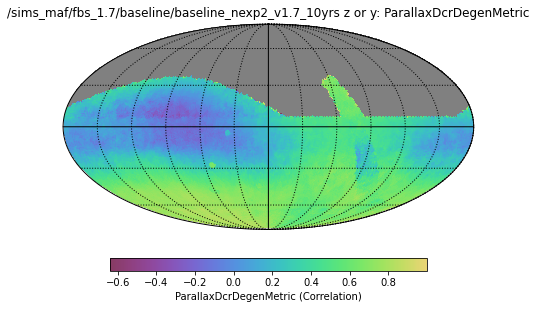

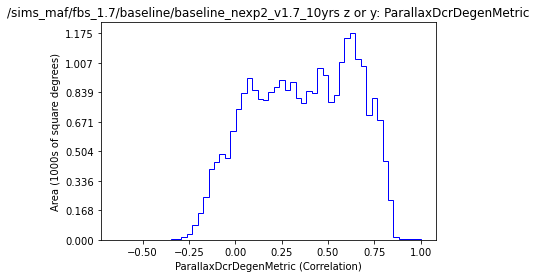

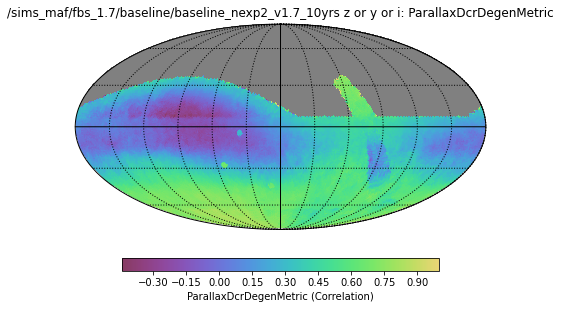

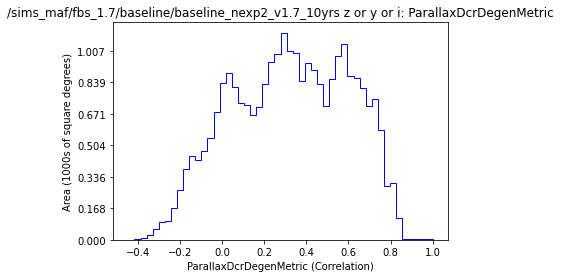

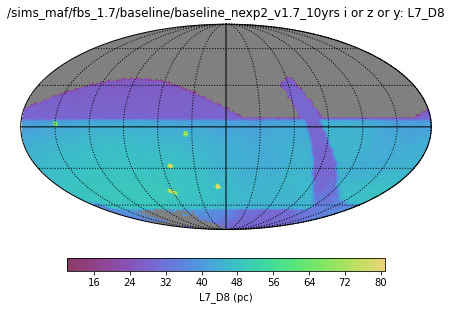

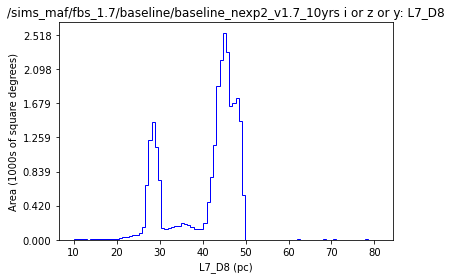

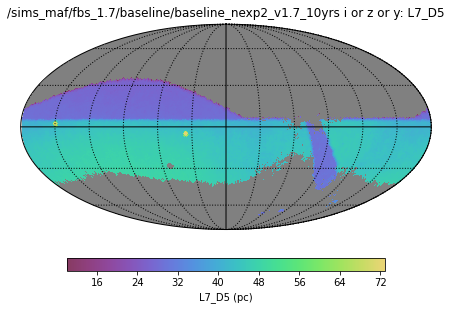

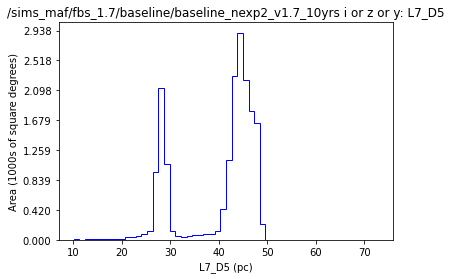

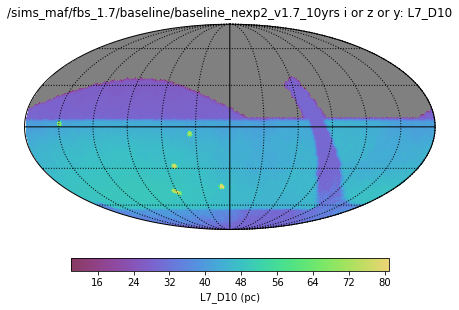

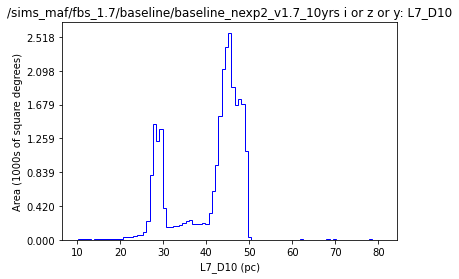

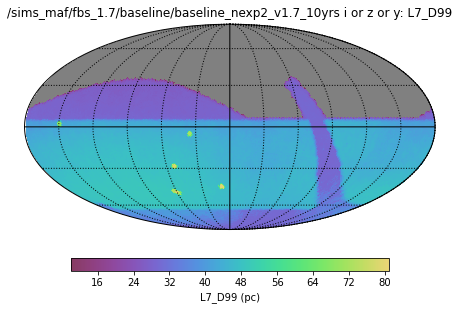

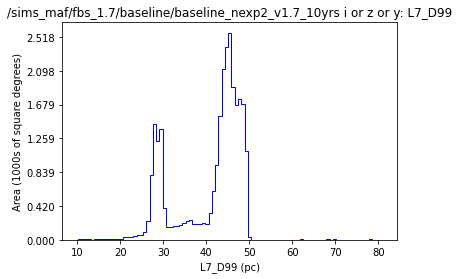

In [6]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

In [7]:
# Print out the total volume probed (pc^3)
for bl in bundleList:
    print(bl.metric.name, bl.summaryValues)

L7_D8 {'VolumeSum': 206283.18428065826}
L7_D5 {'VolumeSum': 131650.7197948514}
L7_D10 {'VolumeSum': 208944.96197726647}
L7_D99 {'VolumeSum': 208944.96197726647}
ParallaxDcrDegenMetric {}
ParallaxDcrDegenMetric {}


In [8]:
good = np.where(bundleList[2].metricValues > 130)
np.median(bundleList[2].metricValues[good])

/data0/sw.tmpfs/lsst_stack-2021.10.13/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


masked

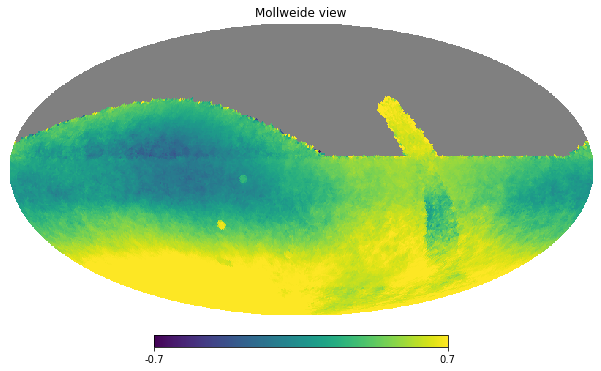

In [9]:
hp.mollview(bundleList[-2].metricValues, min=-.7, max=0.7)

In [10]:
# make a histogram the way the referee likes.
area = hp.nside2pixarea(nside, degrees=True)
area_array = np.zeros(bundleList[-2].metricValues.size) + area
area_array[bundleList[0].metricValues.mask] = 0

Text(0.5, 1.0, '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs')

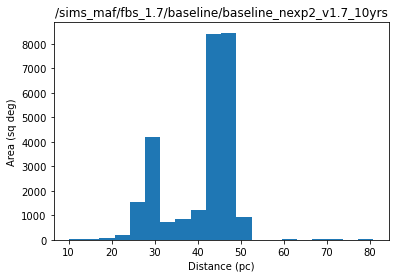

In [11]:
_ack = plt.hist(bundleList[0].metricValues, weights=area_array, bins=20)
plt.xlabel('Distance (pc)')
plt.ylabel('Area (sq deg)')
plt.title(bundleList[0].runName)

In [12]:
print(area_array)



[0.         0.         0.         ... 0.         0.83929365 0.        ]
